In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import sympy
from itertools import product

import lsrl
from lsrl.matrix_tools import Matrix, MatrixMode, set_global_matrix_mode

/homes/cdt21/aleks/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


This notebook illustrates the construction of in-context model that can emulate any map from token sequences to token sequences. This follows closely Lst. 2 in the paper. Note that we are implementing it only with `f_ifelse_mul` which utilizes multiplicative gating. The rest of the `f_ifelse` implementations and extensive testing with both the symbolic and numeric modes are available in `test_ua_tok2tok.py`.

In [2]:
# This sets all the computations to be numeric.
set_global_matrix_mode(MatrixMode.NUMERIC)

Let's build the program:

In [3]:
seq_len = 3 # the number of tokens in the key and value of our target map
scale = 1000

input = lsrl.Input(dim=1)

const_0 = lsrl.f_constant(input, 0)
const_1 = lsrl.f_constant(input, 1)

# this counter starts at 0
global_counter = lsrl.LinState(
    input=const_1,
    A=Matrix.eye(1),
    B=Matrix.eye(1),
    init_state=Matrix([[-1]]),
    name="GlobalCounter",
)
modT_counter = lsrl.f_modulo_counter(input, seq_len)
mod2T_counter = lsrl.f_modulo_counter(input, 2 * seq_len)

# adding the 0.5 for numerical stability
is_prompt = lsrl.f_larger(global_counter, seq_len - 0.5, scale=scale)
is_compare_mode = lsrl.f_larger(mod2T_counter, seq_len - 0.5, scale=scale)
is_copy_mode = lsrl.f_and(
    is_prompt,
    lsrl.f_not(is_compare_mode),
    scale=scale,
)
is_first_token_for_copy = lsrl.f_and(
    is_copy_mode,
    lsrl.f_smaller(modT_counter, 0.5, scale=scale),
    scale=scale,
)

# tmp var to hold the update to the state that keeps the input
# t_query_update_single = lsrl.f_ifeq(is_prompt, const_0, input, const_0, scale=STEP_SCALE)
t_query_update_single = lsrl.f_ifelse_mul(
    lsrl.f_smaller(is_prompt, 0.5, scale=scale), 
    t_val=input, 
    f_val=None, 
)

t_query_update_whole_seq = []
for i in range(seq_len):  # this creates self.seq_len individual operations
    t_query_update_whole_seq.append(
        lsrl.f_ifelse_mul(
            lsrl.f_and(lsrl.f_larger(modT_counter, i - 0.5, scale=scale), lsrl.f_smaller(modT_counter, i + 0.5, scale=scale)),
            t_val=t_query_update_single,
            f_val=None,
        )
    )

query = lsrl.LinState(
    input=lsrl.Concat(t_query_update_whole_seq),
    A=Matrix.eye(seq_len),
    B=Matrix.eye(seq_len),
    init_state=Matrix.zeros(seq_len, 1),
    name="Query",
)

# if we are in compare mode check if the current
# element matches the one in the same position in the query
corresponding_query_element_whole_seq = []
for i in range(seq_len):  # this creates seq_len individual operations
    corresponding_query_element_whole_seq.append(
        lsrl.f_ifelse_mul(
            lsrl.f_and(
                lsrl.f_larger(modT_counter, i - 0.5, scale=scale),
                lsrl.f_smaller(modT_counter, i + 0.5, scale=scale),
            ),
            t_val=query[i],
            f_val=None,
        )
    )

# sum the elements (only one should be no-zero)
corresponding_query_element = lsrl.Linear(
    input=lsrl.Concat(corresponding_query_element_whole_seq),
    A=Matrix.ones(1, seq_len),
    b=Matrix.zeros(1, 1),
)

matching = lsrl.f_and(
    x=lsrl.f_and(
        lsrl.f_larger(input, corresponding_query_element - 0.5, scale=scale),
        lsrl.f_smaller(input, corresponding_query_element + 0.5, scale=scale),
    ),
    y=is_compare_mode,
    scale=scale,
)

# keep a buffer of the last last T+1 values to check if we have a whole sequence match
# the +1 is because we can only read from the buffer after we write to it
shift_matrix = sympy.SparseMatrix.zeros(seq_len + 1,seq_len + 1)
for i in range(seq_len):
    shift_matrix[i, i + 1] = 1
shift_matrix = Matrix(shift_matrix)

buffer = lsrl.LinState(
    input=matching,
    A=shift_matrix,
    B=Matrix([[0] for _ in range(seq_len)] + [[1]]),
    init_state=Matrix.zeros(seq_len + 1, 1),
    name="Buffer",
)

# if the first seq_len intems in the buffer are matching, then we have our whole sequence match
buffer_sum = lsrl.Linear(
    input=buffer,
    A=Matrix([[1 for _ in range(seq_len)] + [0]]),
    b=Matrix.zeros(1, 1),
)
all_matching = lsrl.f_larger(
    buffer_sum,
    seq_len - 0.5,
    scale=scale,
)

# we have a state that designates when we have started copying
# this would be zero until we have a complete match of the key
# then it turns to the current counter number so that we can copy the
# next seq_len tokens into a register as these are the values we need to
# output at the end

matching_and_first_for_copy = lsrl.f_and(all_matching, is_first_token_for_copy, scale=scale)
t_started_on_update = lsrl.f_ifelse_mul(
    matching_and_first_for_copy, 
    t_val=global_counter, 
    f_val=None, 
)
started_on = lsrl.LinState(
    input=t_started_on_update,
    A=Matrix.eye(1),
    B=Matrix.eye(1),
    init_state=Matrix.zeros(1, 1),
    name="Started on",
)

# this variable designates whether we should be copying into the output register
# should be true for seq_len steps after started_on
is_copying_on = lsrl.f_smaller(global_counter, started_on + seq_len, scale=scale)

# if we are copying, copy the current value in the corresponding position in the register
# the register has seq_len Linear States, one for each output
copy_and_on = lsrl.f_and(is_copy_mode, is_copying_on, scale=scale)
modT_counter_equal_to_i = [
    lsrl.f_and(
        lsrl.f_larger(modT_counter, i - 0.5, scale=scale),
        lsrl.f_smaller(modT_counter, i + 0.5, scale=scale),
        scale=scale,
    )
    for i in range(seq_len)
]
t_register_updates_should_update = [
    lsrl.f_and(x=copy_and_on, y=modT_counter_equal_to_i[i], scale=scale) for i in range(seq_len)
]

t_register_updates = [
    lsrl.f_ifelse_mul(
        lsrl.f_larger(t_register_updates_should_update[i], 0.5, scale=scale), 
        t_val=input, 
        f_val=None,
    )
    for i in range(seq_len)
]

output_registers = [
    lsrl.LinState(
        input=update,
        A=Matrix.eye(1),
        B=Matrix.eye(1),
        init_state=Matrix.zeros(1, 1),
    )
    for update in t_register_updates
]

# The only thing left is to output the corrsponding values from each register
# we only care about the last seq_len outputs but nothing stops us from just
# repeating the output one we know what it should be
t_output_individual_updates = [
    lsrl.f_ifelse_mul(
        lsrl.f_larger(modT_counter_equal_to_i[i], 0.5, scale=scale),
        t_val=output_registers[i],
        f_val=None,
    )
    for i in range(seq_len)
]

# sum the individual updates
output = lsrl.Linear(
    input=lsrl.Concat(t_output_individual_updates),
    A=Matrix.ones(1, seq_len),
    b=Matrix.zeros(1, 1),
)

loop = lsrl.ForEach(output, verbose=False)

We can try to visualize the computation graph (the DAG) of the above program, but it is quite complex and large:

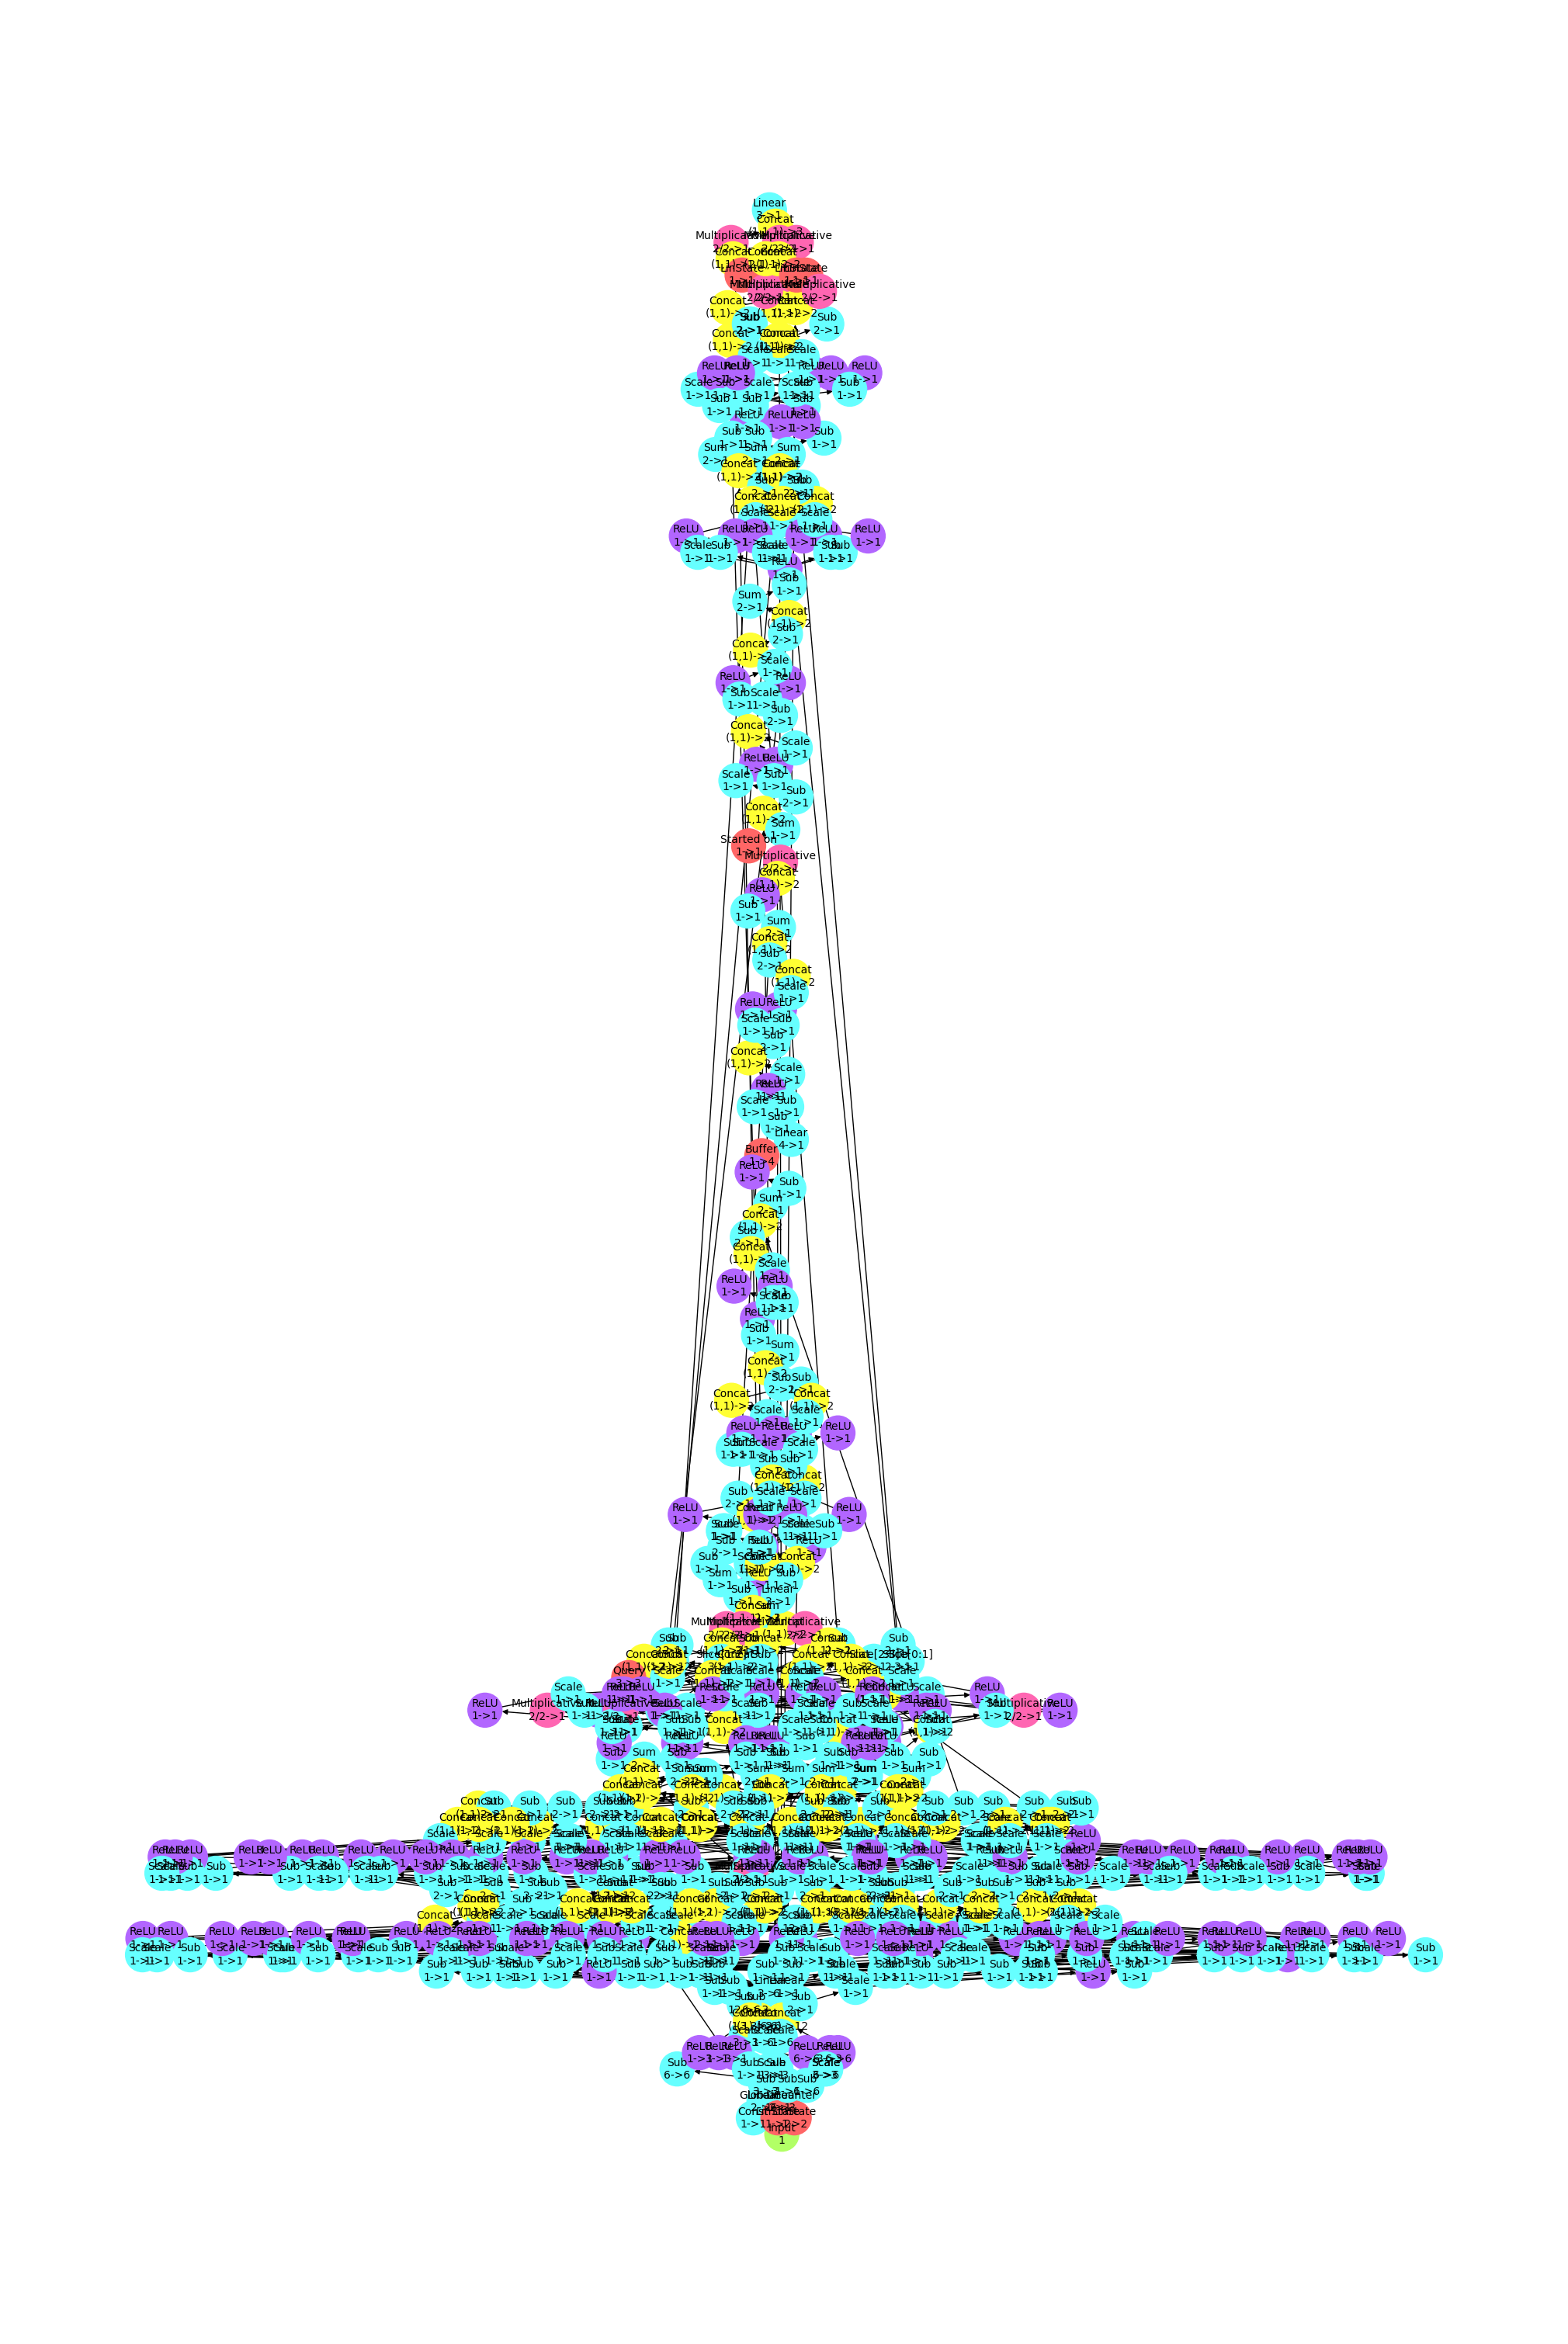

In [4]:
lsrl.utils.plot_and_save_graph(loop.graph(), figsize=(20,30))

As you can see, it has a lot of branching and hence cannot directly be represented as neural network.
We can thus apply the debranching procedure outlined in the paper and compile this computation graph to a path graph that has a natural representation as a neural network model.

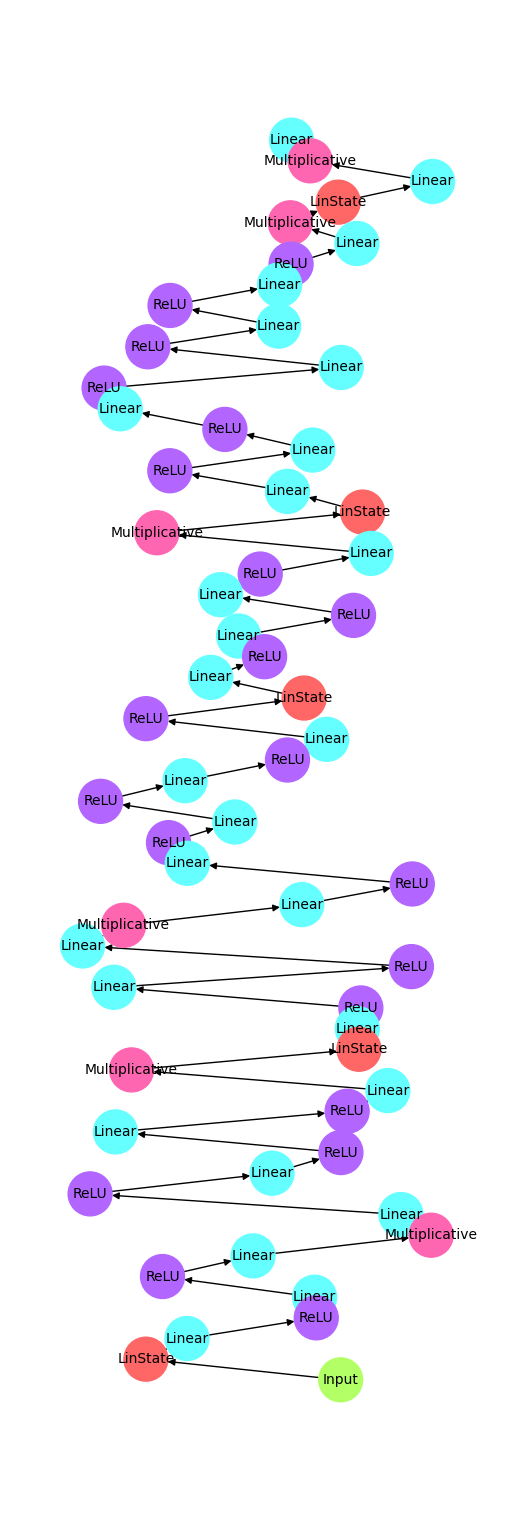

In [5]:
loop.verbose = False
loop.simplify()
lsrl.utils.plot_and_save_graph(loop.graph(), figsize=(5,15), node_types_instead_of_name=True)

Thanks to this simplification step you can see that the underlying model is much more simple!

Now, lets evaluate that the model is correct, in other words that it does what we expect it to do: approximate a given target function. We create a test target function, and evaluate it at a number of points to show that our approximation is correct.

In [6]:
country_capitals = {
    "AUS": "VIE",  # Vienna
    "BUL": "SOF",  # Sofia
    "CAN": "OTT",  # Ottawa
    "DEN": "COP",  # Copenhagen
    "ENG": "LON",  # London
    "FRA": "PAR",  # Paris
    "GER": "BER",  # Berlin
    "HUN": "BUD",  # Budapest
    "IND": "NEW",  # New Delhi
    "JAP": "TOK",  # Tokyo
    "KEN": "NAI",  # Nairobi
    "LUX": "LUX",  # Luxembourg
    "MEX": "MEX",  # Mexico City
    "NOR": "OSO",  # Oslo
    "OMA": "MUS",  # Muscat
    "POL": "WAR",  # Warsaw
    "QAT": "DOH",  # Doha
    "RUS": "MOS",  # Moscow
    "SPA": "MAD",  # Madrid
    "TUR": "ANK",  # Ankara
    "USA": "WAS",  # Washington, D.C.
    "VEN": "CAR",  # Caracas
    "WAL": "CAR",  # Cardiff
    "YEM": "SAN",  # Sana'a
    "ZIM": "HAR"   # Harare
}

def letter_to_number(letter):
    return ord(letter.upper()) - ord('A') + 1

def number_to_letter(number):
    return chr(number + ord('A') - 1)

country_capitals_tokenized = {
    (letter_to_number(kk) for kk in k): (letter_to_number(vv) for vv in v) 
    for k, v in country_capitals.items()
}

# construct the prompt, that is, a sequence of (key,value) pairs
prompt_concat_pairs = [list(xx) + list(yy) for xx, yy in country_capitals_tokenized.items()]
prompt = [item for sublist in prompt_concat_pairs for item in sublist]

Now, let's evaluate it for one of the countries:

In [7]:
query = "CAN"
query_tokenized = [letter_to_number(q) for q in query]
full_input = np.concatenate((query_tokenized, prompt))
print("Full input (query+prompt):")
print("".join([number_to_letter(t) for t in full_input]))

answer = loop(full_input[None, :]).numpy()[:, -seq_len:].flatten() # we only need the last N tokens
answer_letters = "".join([number_to_letter(int(t.round())) for t in answer])
print(f"Given the query {query}, the model's guess is {answer_letters}")
print(f"That is the {'correct answer! ✅' if answer_letters==country_capitals[query] else 'wrong answer! ❌'}")

Full input (query+prompt):
CANAUSVIEBULSOFCANOTTDENCOPENGLONFRAPARGERBERHUNBUDINDNEWJAPTOKKENNAILUXLUXMEXMEXNOROSOOMAMUSPOLWARQATDOHRUSMOSSPAMADTURANKUSAWASVENCARWALCARYEMSANZIMHAR
Given the query CAN, the model's guess is OTT
That is the correct answer! ✅
